In [ ]:
import jax
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from matplotlib.animation import FuncAnimation

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 18

In [3]:
def rk4_step(y, i, dt, f):
    h = dt
    t = dt * i
    k1 = h * f(y, t)
    k2 = h * f(y + k1 / 2, dt * i + h / 2)
    k3 = h * f(y + k2 / 2, t + h / 2)
    k4 = h * f(y + k3, t + h)

    y_next = y + 1 / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return y_next

    

@partial(jax.jit, static_argnames=("f",))
def rk4(ys, dt, N, f):
    """
    Based on
    https://colab.research.google.com
    github/google/jax/blob/master/cloud_tpu_colabs/Lorentz_ODE_Solver
    """
    @jax.jit
    def step(i, ys):
        ysi = rk4_step(ys[i - 1], i, dt, f)
        return ys.at[i].set(ysi)
    return jax.lax.fori_loop(1, N, step, ys)

# Modified Lorenz 96 model
See https://en.wikipedia.org/wiki/Lorenz_96_model


$$
    \dot{\bf x}_k = \Big({\bf x}_{k+1} - {\bf x}_{k-2}\Big) {\bf x}_{j-1} - {\bf x}(j) + {F}_k
$$
with 
* $F_k \sim {\cal N}(8, 1)$

In [4]:
D = 40
F = 8.0
# ixs = jnp.arange(D)

key = jax.random.PRNGKey(31415)
key_init, key_sim, key_eval = jax.random.split(key, 3)
x0 = jax.random.normal(key_init, (D,)) + F

key_state, key_measurement = jax.random.split(key_sim)

In [5]:
@partial(jax.vmap, in_axes=(None, 0, None))
def fcoord(x, k, D):
    xdot = (x[(k + 1) % D] - x[k - 2]) * x[k - 1] - x[k] + F
    return xdot

def f(x, t, D, *args):
    keyt = jax.random.fold_in(key_state, t)
    err = jax.random.normal(keyt, shape=(D,))
    ixs = jnp.arange(D)
    xdot = fcoord(x, ixs, D) + F #+ err
    return xdot

In [6]:
N = 60
dt = 0.05
xs = jnp.zeros((N,) + x0.shape)
xs = xs.at[0].set(x0)
fpart = partial(f, D=D)
xs = rk4(xs, dt, N, fpart)
ys = xs + jax.random.normal(key_measurement, xs.shape)

In [7]:
ys_corrupted = ys.copy()
p_err = 0.01
errs_map = jax.random.bernoulli(key_init, p=p_err, shape=ys_corrupted.shape)
ys_corrupted = ys_corrupted * (~errs_map) + 100.0 * errs_map
err_where = np.where(errs_map)

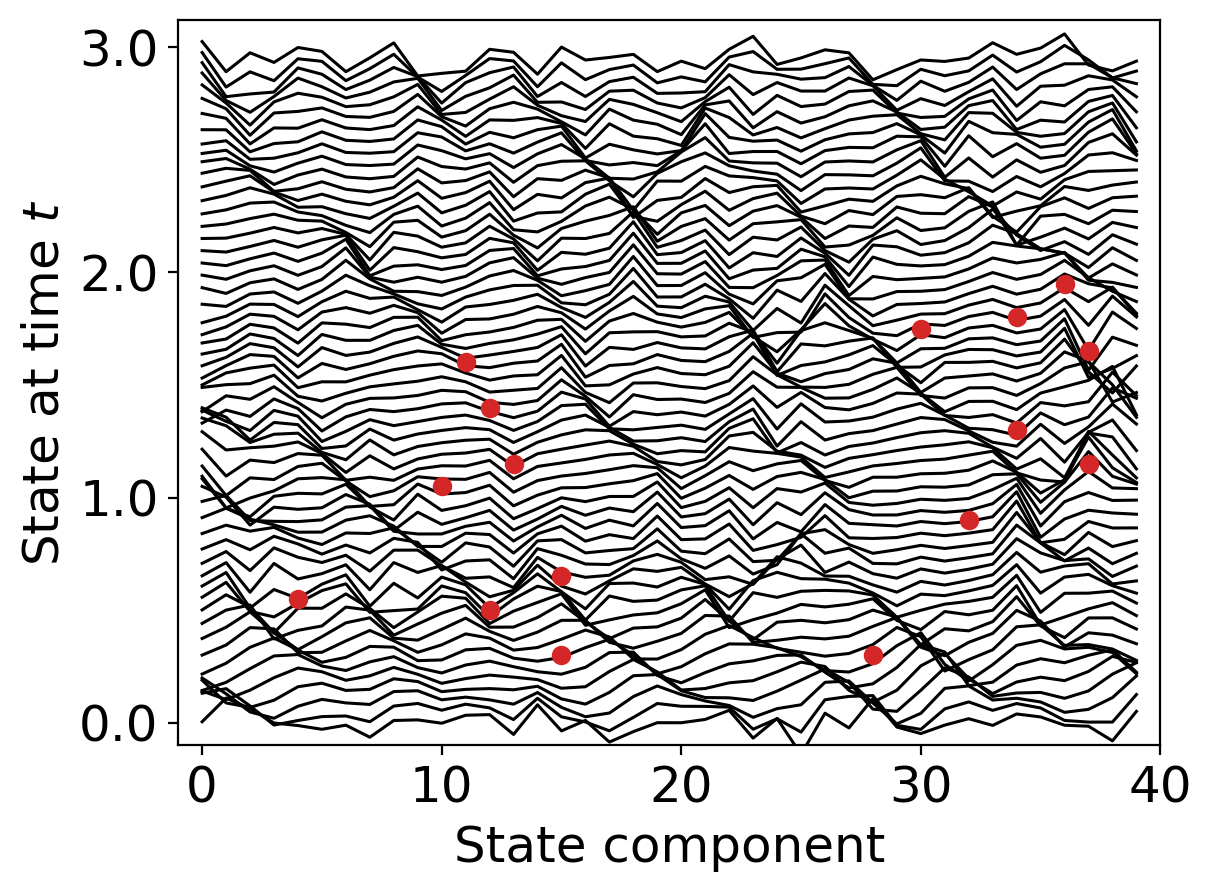

In [8]:
xs_cpu = np.array(xs)
for n, row in enumerate(xs):
    # plt.axhline(y=n, c="tab:gray", zorder=1, alpha=0.2)
    plt.plot((row - row.mean()) / row.std() + n, c="black", zorder=1, linewidth=1.1)
plt.xlabel("State component")
plt.ylabel("State at time $t$")
pos, vals = plt.yticks()
plt.yticks(pos[1:-1], pos[1:-1] * dt);
plt.ylim(bottom=pos[1] - 2, top=pos[-2] * 1.04)
plt.xlim(-1, D)
plt.scatter(*err_where, c="tab:red")

plt.tight_layout()

In [19]:
snapshots = 50

nlines = 60
N = nlines * snapshots
dt = 0.05
x0 = 8.0 + jax.random.normal(key_init, (D,))
xs = jnp.zeros((N,) + x0.shape)
xs = xs.at[0].set(x0)
fpart = partial(f, D=D)
xs = rk4(xs, dt, N, fpart)
ys = xs + jax.random.normal(key_measurement, xs.shape)

xs_cpu = np.array(xs)
ys_cpu = np.array(ys)

MovieWriter ffmpeg unavailable; using Pillow instead.


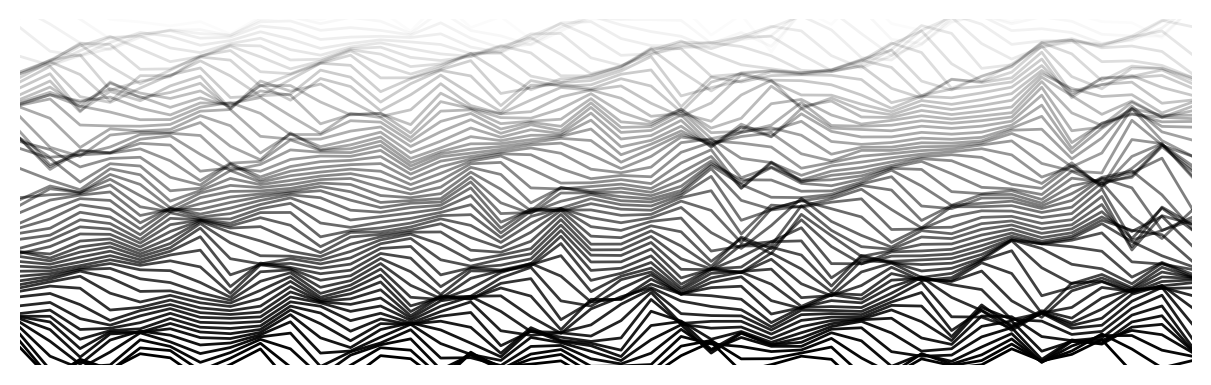

In [20]:
nlines = 60
xrange = np.linspace(0, 1, D)

fig, ax = plt.subplots(figsize=(6.4, 4.8))

# fig.set_size_inches(6, 2)
fig.set_size_inches(6.4, h=2.3)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

spacing = 0.5
def anim(i):
    ax.cla()
    for n, row in enumerate(xs_cpu[i:i + nlines][::-1]):
        yval = (row - row.mean()) / row.std() + n * spacing
        ax.plot(xrange, yval, c="black", linewidth=1.0, zorder=2,
            alpha = 1 - n / nlines
        )
    ax.set_ylim(0, (nlines - 1) * spacing)
    ax.set_xlim(0, 1)
    ax.axis("off")
    ax.set_aspect(0.01)
    plt.tight_layout()

# animation = FuncAnimation(fig, anim, frames=10)
animation = FuncAnimation(fig, anim, frames=snapshots)
animation.save("./figures/waves.gif", fps=10, dpi=100)

In [213]:
np.random.seed(314)
p = 0.002
errs = np.random.choice(2, size=xs_cpu.shape, p=[1-p, p])

xs_corrupt = 100 * errs + (1 - errs) * xs_cpu
any_corrupt = errs.any(axis=1)

MovieWriter ffmpeg unavailable; using Pillow instead.


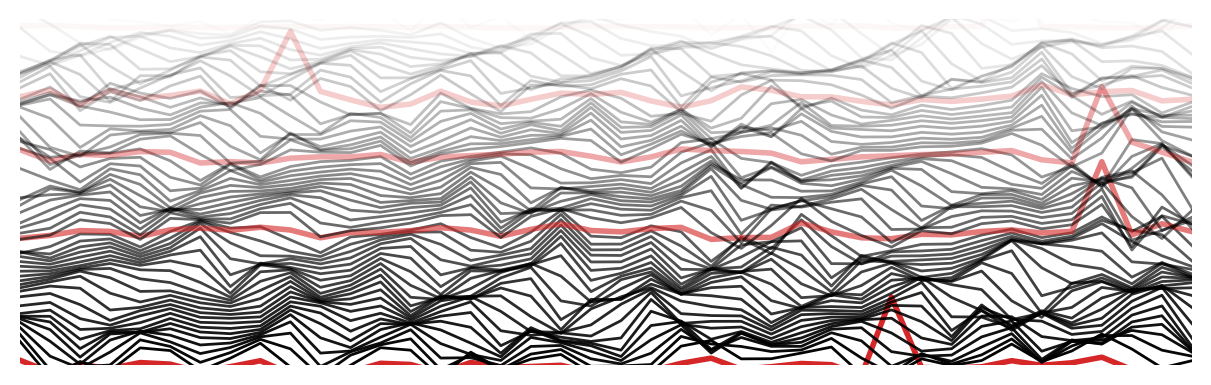

In [214]:
fig, ax = plt.subplots(figsize=(6.4, 4.8))

# fig.set_size_inches(6, 2)
fig.set_size_inches(6.4, h=2.3)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

spacing = 0.5
def anim(i):
    ax.cla()
    vslice = slice(i, i + nlines)
    for n, (row, anyc) in enumerate(zip(xs_corrupt[vslice][::-1], any_corrupt[vslice][::-1])):
        c = "tab:red" if anyc else "black"
        l = 2 if anyc else 1
        
        yval = (row - row.mean()) / row.std() + n * spacing
        ax.plot(xrange, yval, c=c, linewidth=l, zorder=1,
            alpha = 1 - n / nlines
        )
    ax.set_ylim(0, (nlines - 1) * spacing)
    ax.set_xlim(0, 1)
    ax.axis("off")
    ax.set_aspect(0.01)
    plt.tight_layout()
    
# animation = FuncAnimation(fig, anim, frames=10)
animation = FuncAnimation(fig, anim, frames=snapshots)
animation.save("./figures/waves-corrupt.gif", fps=10, dpi=100)

In [21]:
# Static plot

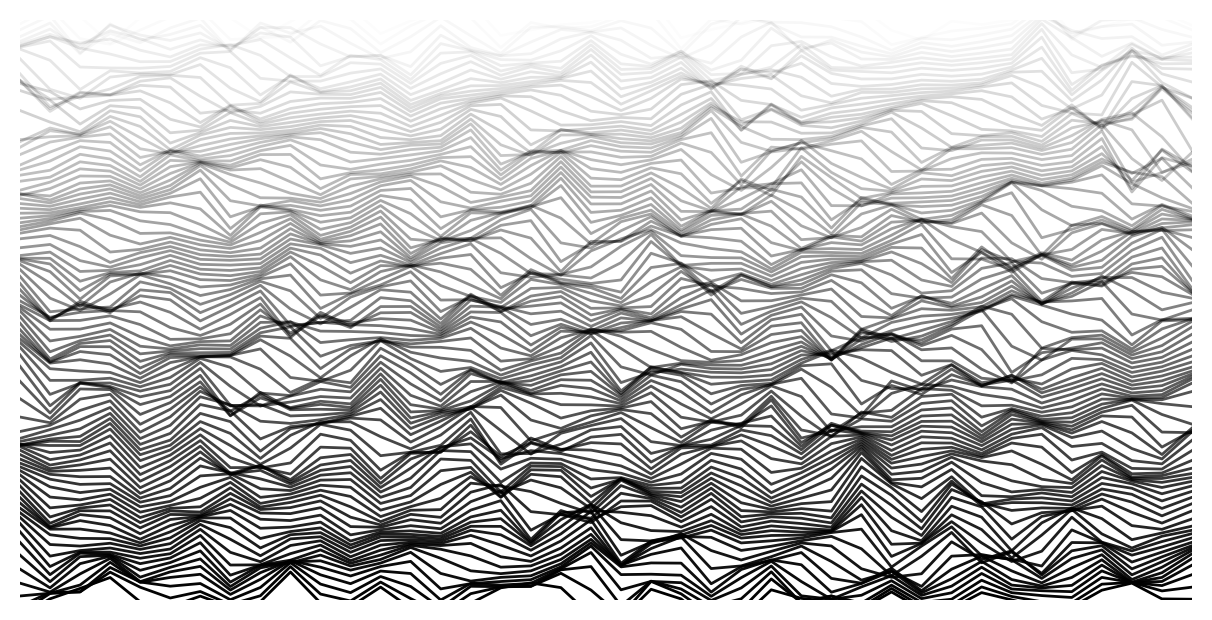

In [46]:
nlines = 100
xrange = np.linspace(0, 1, D)

fig, ax = plt.subplots(figsize=(6.4, 4.8))

# fig.set_size_inches(6, 2)
fig.set_size_inches(6.4, h=4.8)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

spacing = 0.5
def anim(i):
    ax.cla()
    for n, row in enumerate(xs_cpu[i:i + nlines][::-1]):
        yval = (row - row.mean()) / row.std() + n * spacing
        ax.plot(xrange, yval, c="black", linewidth=1.0, zorder=2,
            alpha = 1 - n / nlines
        )
    ax.set_ylim(0, (nlines - 1) * spacing)
    ax.set_xlim(0, 1)
    ax.axis("off")
    ax.set_aspect(0.01)
    plt.tight_layout()

anim(10)
plt.savefig("./figures/waves.png", dpi=300, bbox_inches="tight")